# Partie III: Visualisation

Le but de cette partie est de compléter ce projet en lui ajoutant un ensemble de représentations visuelles de nos résulats, ce qui fait parfaitement sens
dans l'optique de l'étude de la carte des départements. Les modélisations réalisées ne seront pas toujours excatement similaires à celle de la partie 2, 
mais aboutissent et complètent les mêmes conclusions. 

Nous reviendrons d'abord sur quelques cartographie réalisées pour explorer des pistes quelques pistes et avoir nos premières représentation des maladies par 
departement, puis nous continuerons sur le clustering et les résultats analogue à la deuxieme partie. 

# Import des packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install pygeos
!pip install topojson
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
from sklearn.cluster import KMeans
import seaborn as sns
import plotly.express as px
!pip install --upgrade geopandas matplotlib
#!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
#!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

In [2]:
base_grande = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')

base_grande = base_grande.dropna()

base_grande = pd.get_dummies(base_grande, prefix = 'indicatrice_', columns=['patho_niv1'], dtype='int')

base_grande["classe_age"] = base_grande["cla_age_5"].apply(
    lambda x: np.mean(list(map(lambda y : int(y), x.split("-")))) if "-" in x else (np.nan if x == 'tsage' else 100)
)


## Premières cartographies : la représentation d'un taux de contraction d'une maladie par département
Exemple de cartographie pour commencer la visualisation de la répartition des maladies. La première porte sur les cancers parce que les conséquences de la pollution sur la santé sont maintenant acceptées. Nous cherchions à savoir s'il nous était possible de retrouver de tels corrélations à partir de nos données (qui manquent parfois de précision).

In [3]:
base_grande = base_grande.drop(['top', 'cla_age_5', 'patho_niv2', 'patho_niv3', 'annee', 
                                'libelle_classe_age', 'sexe', 'libelle_sexe'], axis = 1)
df_model_cancer = base_grande[['dept', 'classe_age', 'indicatrice__Cancers']]

In [4]:
#https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb

In [5]:
#debut de la création de carte

In [6]:
france = gpd.read_file('https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


<Axes: >

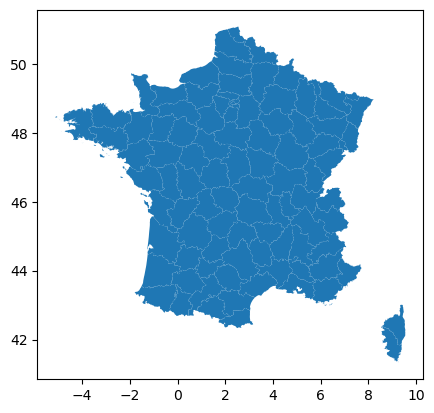

In [7]:
france.plot()

In [8]:
df_carto = pd.merge(left = df_model_cancer, right = france, 
                    how = 'left', left_on='dept', right_on='code')

In [9]:
df_carto['dept'].unique()

array(['971', '973', '999', '75', '94', '95', '25', '58', '27', '61',
       '62', '80', '54', '67', '53', '33', '40', '47', '86', '34', '46',
       '48', '65', '82', '09', '01', '63', '69', '74', '2B', '974', '976',
       '91', '92', '28', '37', '41', '45', '89', '90', '14', '10', '51',
       '52', '57', '08', '49', '72', '85', '35', '56', '24', '64', '12',
       '66', '03', '38', '42', '06', '84', '78', '18', '21', '02', '68',
       '17', '23', '79', '87', '30', '31', '32', '15', '13', '83', '93',
       '36', '70', '55', '44', '16', '19', '11', '43', '04', '05', '2A',
       '972', '77', '88', '29', '26', '07', '39', '50', '59', '60', '76',
       '81', '71', '73', '22'], dtype=object)

##### Nous avons décidé de laisser les DOM-TOM hors de notre analyse car les données à disposition ne recouvrent pas toujours les mêmes territoires entre la base Ameli, celle de la pollution, et celle de la population. 

In [10]:
dept_manquants = ['999', '974', '971', '972', '973', '976']

df_carto = df_carto[~df_carto['dept'].isin(dept_manquants)]

cancer_dep = df_carto.groupby('dept')['indicatrice__Cancers'].sum().reset_index()

df_carto = df_carto.merge(cancer_dep, on='dept', suffixes=('', '_sum'))

df_carto = gpd.GeoDataFrame(df_carto, crs='EPSG:4326')

### Première carte

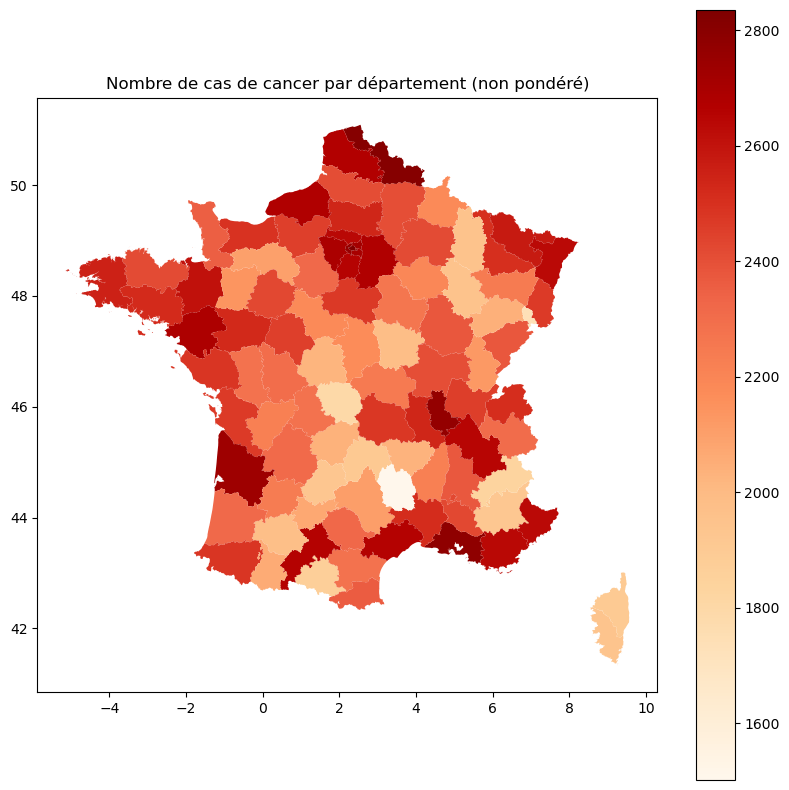

In [11]:
df_carto2 = pd.merge(left = france, right = cancer_dep, 
                    how = 'left', left_on='code', right_on='dept')
fig, ax = plt.subplots(figsize=(10, 10))
df_carto2.plot(ax=ax, column='indicatrice__Cancers', legend=True, cmap='OrRd')
plt.title('Nombre de cas de cancer par département (non pondéré)')
plt.show()

Cette carte représente le nombre de patients étant hospitalisés à cause d'un cancer par département. Il convient néanmoins de remettre en perspective le fait qu'il y a de nombreux patients qui ne sont pas soignés dans leur département. Par ailleurs, il faut également considérer le cas où un patient a vécu toute sa vie dans un département et est hospitalisé une fois qu'il vit dans un nouveau département.  

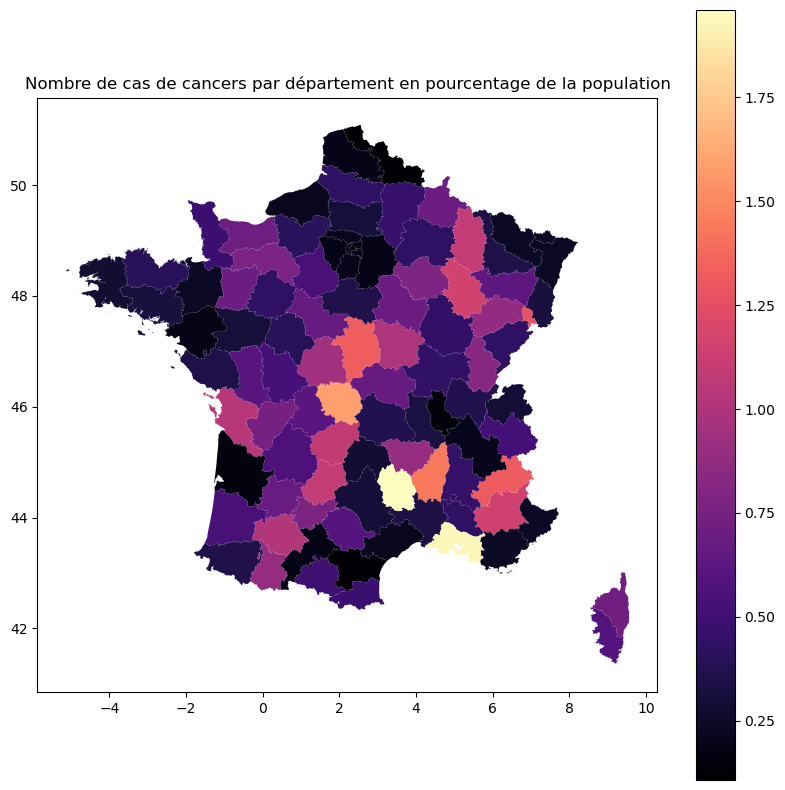

/tmp/ipykernel_6038/1450302337.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = df_carto2.geometry.centroid.unary_union.centroid


In [12]:
base_pop = pd.read_csv("base_pop_dep.csv")

base_pop
df_carto2["pourcentage_cancer"] = (df_carto2["indicatrice__Cancers"] / base_pop["total_habitants"])*100

df_carto2

fig, ax = plt.subplots(figsize=(10, 10))
df_carto2.plot(ax=ax, column='pourcentage_cancer', legend=True, cmap='magma')
plt.title('Nombre de cas de cancers par département en pourcentage de la population')
plt.show()

#effet de population imp? 
#reste a voir avec regression/acp/clustering
#les departements avec les plus grands taux de cancer semblent etre les departements avec la population agee la plus importante
#on ne remarque pas forcement de suite l effet de la pollution sur le nombre de patients atteints de cancer
#paris aurait ete plus eleve

import folium

centroid = df_carto2.geometry.centroid.unary_union.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=10)

for i, row in df_carto2.iterrows():
    folium.GeoJson(
        row['geometry'],
        name=f"Dept: {row['nom']}, Pourcentage Cancer: {row['pourcentage_cancer']}",
        tooltip=f"Dept: {row['nom']}, Pourcentage Cancer: {row['pourcentage_cancer']}",
    ).add_to(m)
m


In [13]:
base_groupe_dep = pd.read_csv('base_groupe_dep_moy_age.csv')

base_groupe_dep = base_groupe_dep.drop(['Unnamed: 0'], axis = 1)

base_groupe_dep = base_groupe_dep[~base_groupe_dep['dept'].isin(dept_manquants)]

base_groupe_dep = base_groupe_dep.merge(base_pop, how='left', left_on = 'dept', right_on = 'numero_dep').drop(['Unnamed: 0'], axis = 1)

base_groupe_dep = base_groupe_dep.set_index('dep')

num_cols_dep = base_groupe_dep.select_dtypes(include=['number']).columns
num_data_dep = base_groupe_dep[num_cols_dep]
scaler = StandardScaler()
base_standard_dep = scaler.fit_transform(num_data_dep)
base_standard_dep = pd.DataFrame(data=base_standard_dep, columns=num_cols_dep, index=base_groupe_dep.index)

In [14]:
base_pop = base_pop.drop(['Unnamed: 0'], axis = 1).set_index('dep')

In [15]:
base_standard_dep = base_standard_dep.drop('indicatrice_Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)', axis = 1)

In [16]:
base_standard_dep = base_standard_dep.drop(['indicatrice_Autres affections de longue durée (dont 31 et 32)',
                                            'indicatrice_Diabète',
                                            'indicatrice_Maladies inflammatoires ou rares ou VIH ou SIDA',
                                            'indicatrice_Maladies neurologiques ou dégénératives',
                                            'indicatrice_Maternité (avec ou sans pathologies)',
                                            'indicatrice_Traitements psychotropes (hors pathologies)',
                                            'indicatrice_Insuffisance rénale chronique terminale',
                                            'indicatrice_Séjours en hospitalisation complète pour prise en charge de la Covid-19',
                                           'indicatrice_Traitements du risque vasculaire (hors pathologies)',
                                           'indicatrice_Maladies psychiatriques'], axis = 1)
#on laisse tomber ces colonnes pour essayer d avoir les maladies qui en theorie devraient 
#etre causees par la pollution

In [17]:
base_standard_dep.columns

Index(['classe_age', 'indicatrice_Cancers',
       'indicatrice_Maladies cardio-neurovasculaires',
       'indicatrice_Maladies du foie ou du pancréas (hors mucoviscidose)',
       'indicatrice_Maladies respiratoires chroniques (hors mucoviscidose)',
       'total_habitants'],
      dtype='object')

# Seconde partie : clustering et visualisation sur l'âge et et la pollution

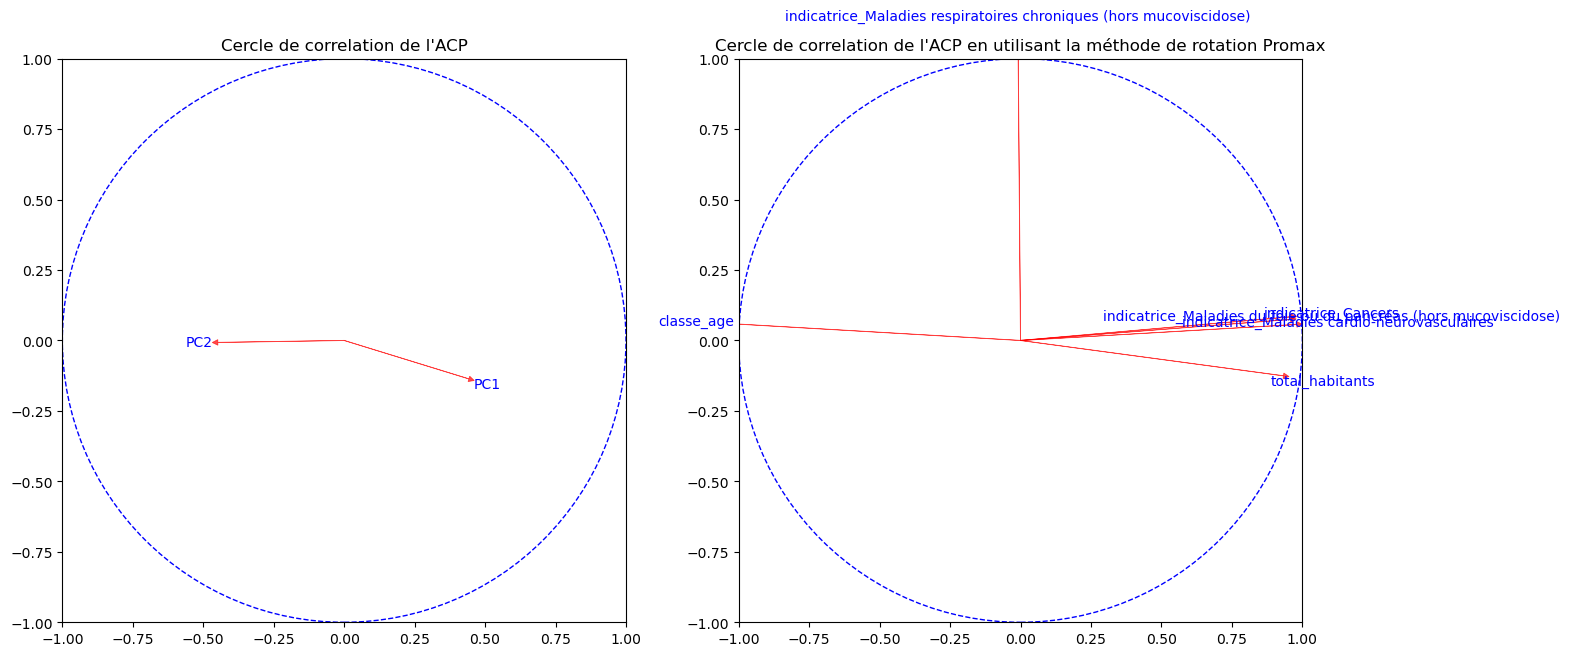

In [18]:
pca = PCA(n_components=2)
pca_result_dep = pca.fit_transform(base_standard_dep)
pca_df_dep = pd.DataFrame(data=pca_result_dep, columns=['PC1', 'PC2'])

# On utilise factor_analyzer pour utiliser la méthode de rotation promax
fa_promax = FactorAnalyzer(n_factors=2, rotation='promax')
fa_promax_result_dep = fa_promax.fit_transform(base_standard_dep)
fa_promax_df_dep = pd.DataFrame(data=fa_promax_result_dep, columns=['Factor1', 'Factor2'])

# On prend les resultats de l'ACP avec la méthode de rotation utilisee
loadings_dep = fa_promax.loadings_
loading_matrix_dep = pd.DataFrame(loadings_dep, columns=['Factor1', 'Factor2'], index=base_standard_dep.columns)
fig, (ax_pca, ax_fa) = plt.subplots(1, 2, figsize=(16, 8))

# On represente graphiquement les cercles de correlation
circle_pca = plt.Circle((0, 0), 1, fill=False, edgecolor='b', linestyle='dashed')
ax_pca.add_patch(circle_pca)
for i, var_pca in enumerate(pca_df_dep.columns):
    ax_pca.arrow(0, 0, pca.components_[0, i], pca.components_[1, i],
                 color='r', alpha=0.7, linewidth=0.5, head_width=0.02, head_length=0.02)
    ax_pca.text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15, var_pca,
                color='b', ha='center', va='center')
ax_pca.set_xlim([-1, 1])
ax_pca.set_ylim([-1, 1])
ax_pca.set_aspect('equal', 'box')
ax_pca.set_title("Cercle de correlation de l'ACP")
circle_fa = plt.Circle((0, 0), 1, fill=False, edgecolor='b', linestyle='dashed')
ax_fa.add_patch(circle_fa)
for i, var_fa in enumerate(loading_matrix_dep.index):
    ax_fa.arrow(0, 0, loading_matrix_dep.loc[var_fa, 'Factor1'], loading_matrix_dep.loc[var_fa, 'Factor2'],
                color='r', alpha=0.7, linewidth=0.5, head_width=0.02, head_length=0.02)
    ax_fa.text(loading_matrix_dep.loc[var_fa, 'Factor1'] * 1.15, loading_matrix_dep.loc[var_fa, 'Factor2'] * 1.15, var_fa,
               color='b', ha='center', va='center')
ax_fa.set_xlim([-1, 1])
ax_fa.set_ylim([-1, 1])
ax_fa.set_aspect('equal', 'box')
ax_fa.set_title("Cercle de correlation de l'ACP en utilisant la méthode de rotation Promax")

plt.show()


Le résultat de l'ACP est assez peu concluant. Malgré avoir retiré beaucoup de variables pour essayer de ne garder que celles qui pouvaient avoir un lien avec la pollution, les composantes principales restent très liées. Et cela quand bien même on utilise Promax ou Varimax. 
Afin de clusteriser nous garderons tout de même ces variables puisqu'elles sont le plus utile qu'on ait pu obtnir mais on sait par avance que les départements qui seront mis dans les mêmes clusters seront les départements avec des caractéristiques démographiques proches. Le poids du nombre de malades ne semble pas pouvoir être démêlé, pour la plupart des cas, du nombre d'habitants d'un département. 

/opt/mamba/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/mamba/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/mamba/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/mamba/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

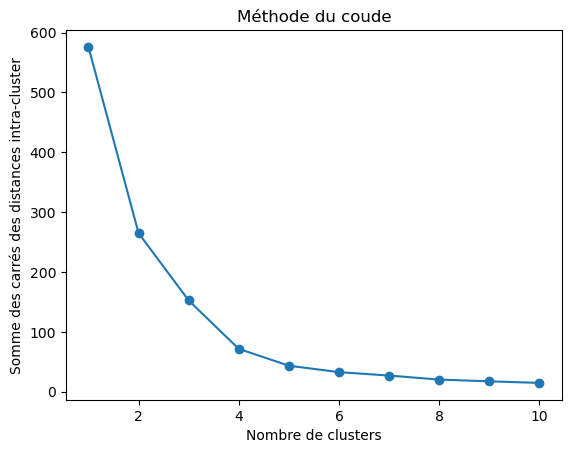

In [19]:
num_clusters_range = range(1, 11)

#On regarde la somme des carrés des distances a l'intérieur de chaque cluster
inertia_values = []
for n_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(base_standard_dep)
    inertia_values.append(kmeans.inertia_)

plt.plot(num_clusters_range, inertia_values, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Somme des carrés des distances intra-cluster')
plt.show()

### Classification des départements en cinq clusters, et leur visualisation
A vrai dire tout ce bout de code n'est que pour pouvoir avoir le graphique "interactif" où on a les départements qui sont affichés et les clusters auxquels ils appartiennent, quand on passe sa souris dessus.

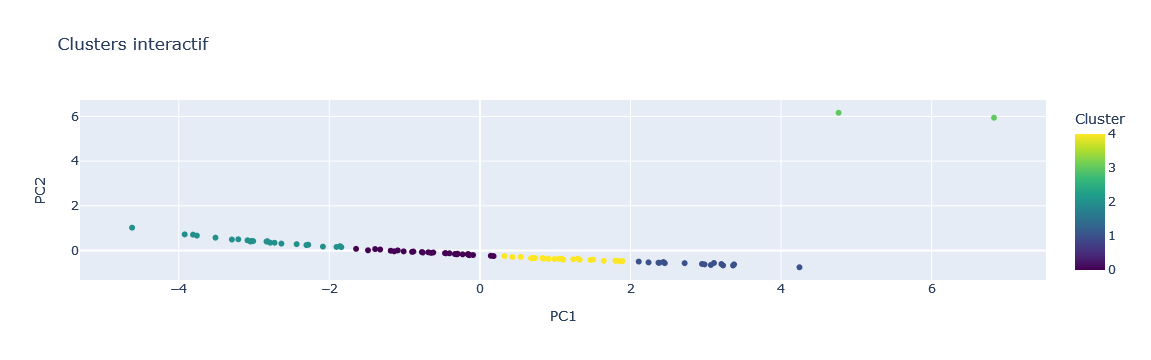

In [20]:
base_standard_dep_reset = base_standard_dep.reset_index()
# On refait les memes opérations que precedemment mais avec l'index reset (il y a eu quelques problemes 
#par rapport a ca donc, ce n est peut etre pas necessaire mais c est plus sur)
pca = PCA(n_components=2)
pca_result_bis = pca.fit_transform(base_standard_dep_reset.drop(columns=['dep']))  
pca_df_reduit = pd.DataFrame(data=pca_result_bis, columns=['PC1', 'PC2'])
fa = FactorAnalyzer(rotation='promax', n_factors=2)
fa.fit(base_standard_dep_reset.drop(columns=['dep']))  
rotated_loadings = fa.loadings_

# On clusterise par la méthode des K-moyennes
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
base_standard_dep_reset['Cluster'] = kmeans.fit_predict(pca_df_reduit)
df_combined = pd.concat([base_standard_dep_reset[['dep', 'Cluster']], pca_df_reduit], axis=1)

# On utilise plotly pour faire le schema interactif
fig = px.scatter(df_combined, x='PC1', y='PC2', color='Cluster',
                 title='Clusters interactif', labels={'Cluster': 'Cluster'},
                 color_continuous_scale='viridis', hover_name='dep')
fig.show()


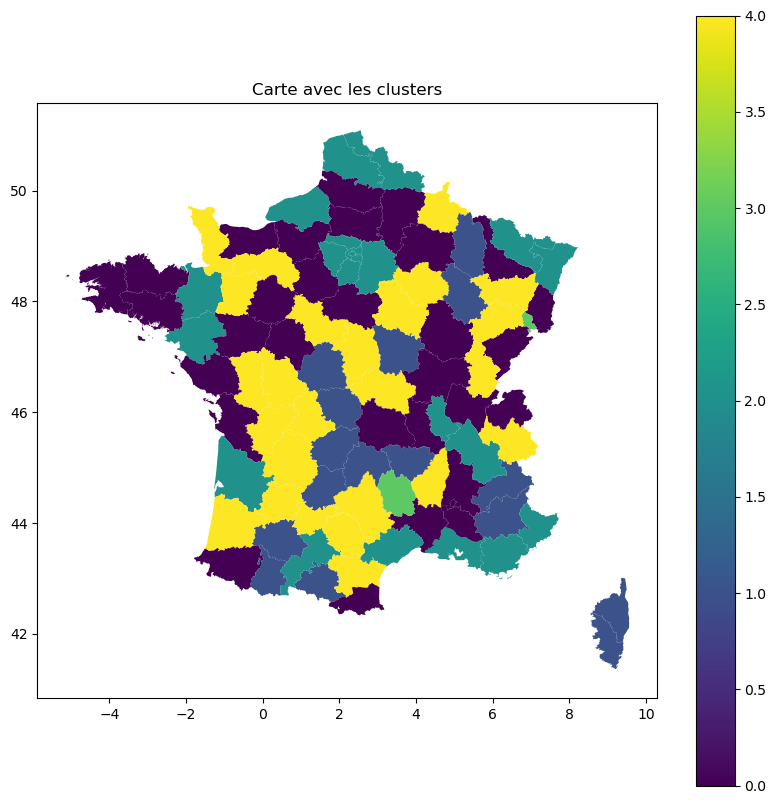

In [21]:
#Manipulations pour retrouver un geodataframe parce qu avec les manipulations precedentes
#il y avait eu des soucis pour "retrouver cette propriete"
standard_dep = base_standard_dep.merge(france, how='left', left_index=True, right_on='nom')
standard_dep = standard_dep.set_index('nom')
base_standard_dep_reset = base_standard_dep_reset.set_index('dep')
cluster_column = base_standard_dep_reset['Cluster']
standard_dep['Cluster'] = cluster_column.loc[standard_dep.index.values]


standard_dep = gpd.GeoDataFrame(standard_dep, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 10))
standard_dep.plot(column='Cluster', cmap='viridis', legend=True, ax=ax)
ax.set_title('Carte avec les clusters')
plt.show()

# On refait la même chose avec une base pondérée par la population

In [22]:
base_pond = base_groupe_dep.drop(['indicatrice_Autres affections de longue durée (dont 31 et 32)',
                                            'indicatrice_Diabète',
                                            'indicatrice_Maladies inflammatoires ou rares ou VIH ou SIDA',
                                            'indicatrice_Maladies neurologiques ou dégénératives',
                                            'indicatrice_Maternité (avec ou sans pathologies)',
                                            'indicatrice_Traitements psychotropes (hors pathologies)',
                                            'indicatrice_Insuffisance rénale chronique terminale',
                                            'indicatrice_Séjours en hospitalisation complète pour prise en charge de la Covid-19',
                                           'indicatrice_Traitements du risque vasculaire (hors pathologies)',
                                           'indicatrice_Maladies psychiatriques'], axis = 1)

In [23]:
base_pond = base_pond.drop('numero_dep', axis = 1)
base_pond = base_pond.drop('dept', axis = 1)

In [24]:
colz = list(base_pond.columns)
colz.remove('total_habitants')

for i in colz : 
    base_pond[i] = (base_pond[i]/base_pond['total_habitants'])*100000
#On multiplie par 100 000 pour avoir des donnees assez eloignees de 0 pour ne pas avoir de problemes dans l ACP ou le clusering
num_cols_pond = base_pond.select_dtypes(include=['number']).columns
num_data_pond = base_pond[num_cols_pond]
scaler = StandardScaler()
standard_ponderee = scaler.fit_transform(num_data_pond)
standard_ponderee = pd.DataFrame(data=standard_ponderee, columns=num_cols_pond, index=base_pond.index)

# On refait une ACP mais avec les données pondérées par la population cette fois.

Cela ne risque pas de changer fondamentalement les résultats mais on préfère en être sûrs.

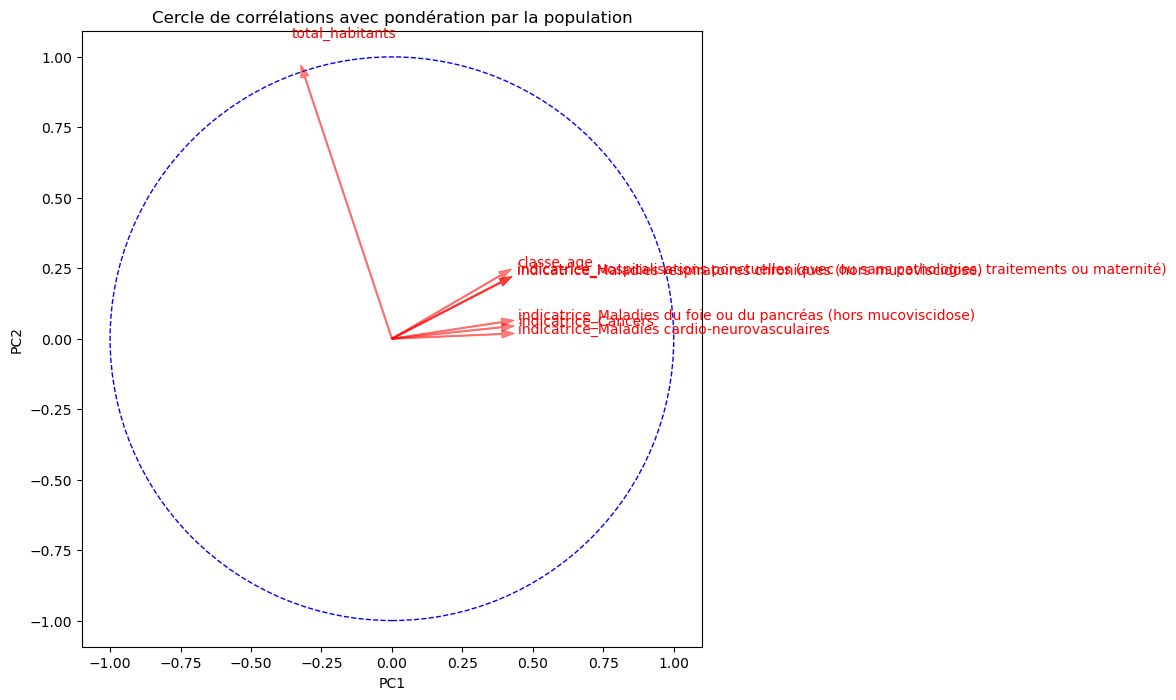

In [25]:
numeric_columns = standard_ponderee.columns[standard_ponderee.dtypes == 'float64']
pca = PCA(n_components=2)
pca_result = pca.fit_transform(standard_ponderee[numeric_columns])
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
plt.figure(figsize=(8, 8))
circle_pca = plt.Circle((0, 0), 1, fill=False, edgecolor='b', linestyle='dashed')
plt.gca().add_patch(circle_pca)

for i, (pc1, pc2, var_name) in enumerate(zip(pca.components_[0], pca.components_[1], numeric_columns)):
    plt.arrow(0, 0, pc1, pc2, color='red', alpha=0.5, width=0.005, head_width=0.03, linewidth=0.5)
    plt.text(pc1 * 1.15, pc2 * 1.15, var_name, color='red')
plt.axis('equal')
plt.title('Cercle de corrélations avec pondération par la population')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Clustering

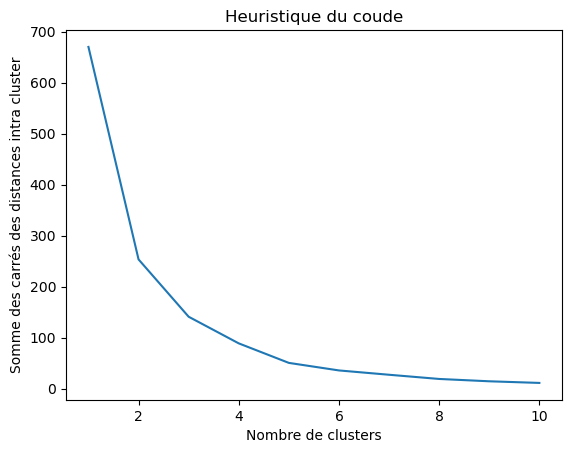

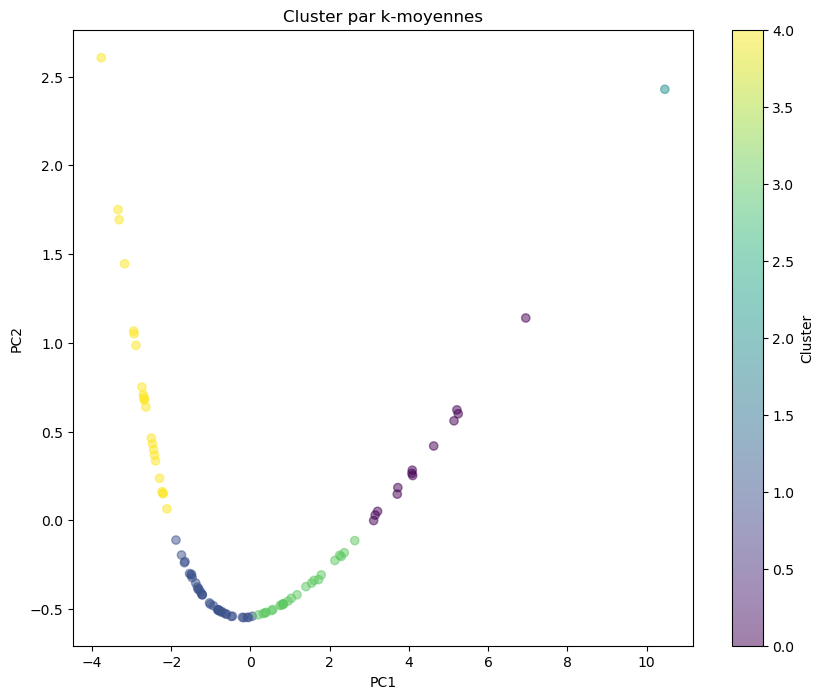

In [26]:
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Heuristique du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Somme des carrés des distances intra cluster')
plt.show()
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
standard_ponderee['Cluster'] = kmeans.fit_predict(pca_df)
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=standard_ponderee['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Cluster par k-moyennes')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

On choisit cinq clusters parce qu'avec d'autres analyses, cinq semblait être le nombre optimal par la méthode du coude. Par ailleurs, cela nous permettrait de faire des comparaisons entre différentes bases de données.

In [27]:
standard_ponderee = standard_ponderee.merge(france, how = 'left', left_index = True, right_on = 'nom')

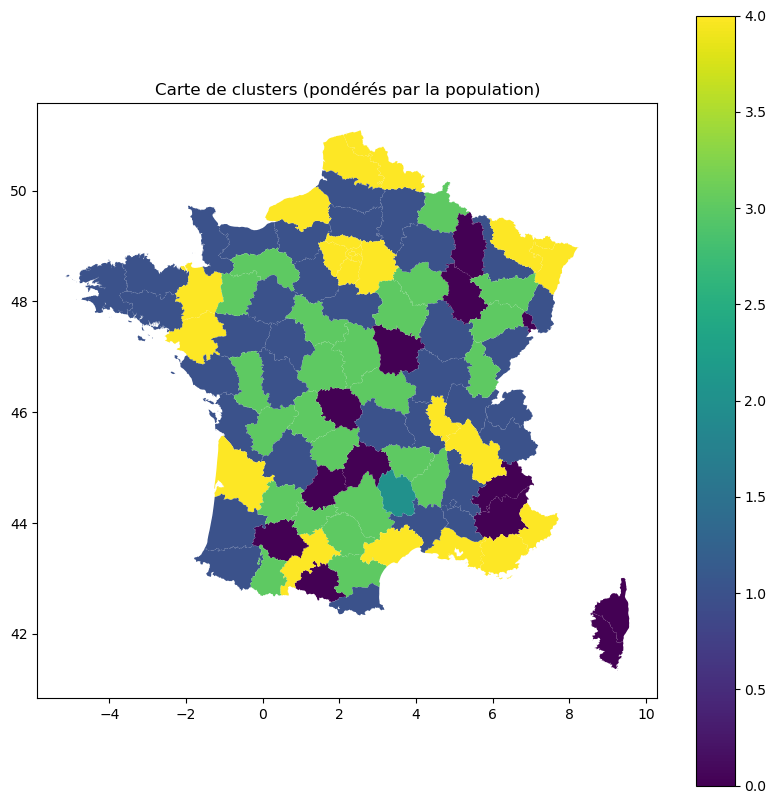

In [28]:
standard_ponderee = gpd.GeoDataFrame(standard_ponderee, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 10))
standard_ponderee.plot(column='Cluster', cmap='viridis', legend=True, ax=ax)
ax.set_title('Carte de clusters (pondérés par la population)')
plt.show()

### Représentation et cartographie avec les données liées à la pollution. 
L'objectif de cette partie était de voir s'il y avait des profils de département similaires qui pourraient coïncider avec le découpage fait au préalable, qui d'une certaine façon est un découpage démographico-pathologique.

In [29]:
base_pollution = pd.read_csv('pollution_group_dep.csv')

base_pollution = base_pollution.merge(france, how = 'left', left_on = 'DEP', right_on = 'code')

base_pollution = base_pollution.drop(['DEP', 'code'], axis = 1)

base_pollution = base_pollution.set_index('nom')

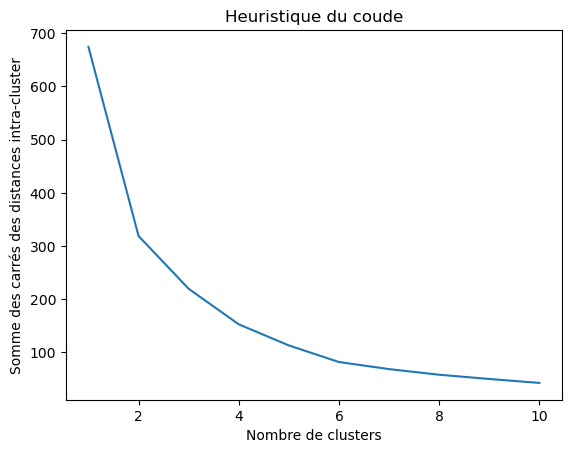

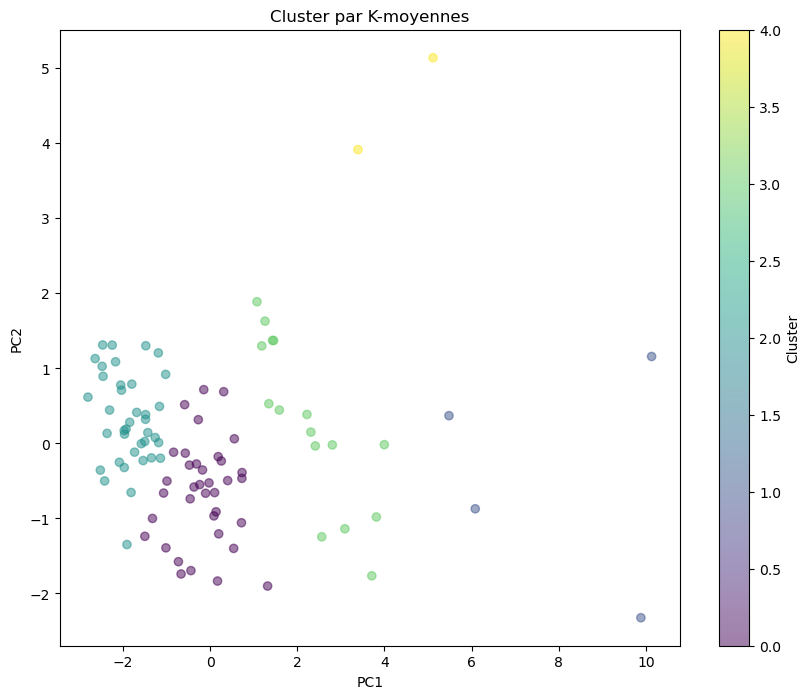

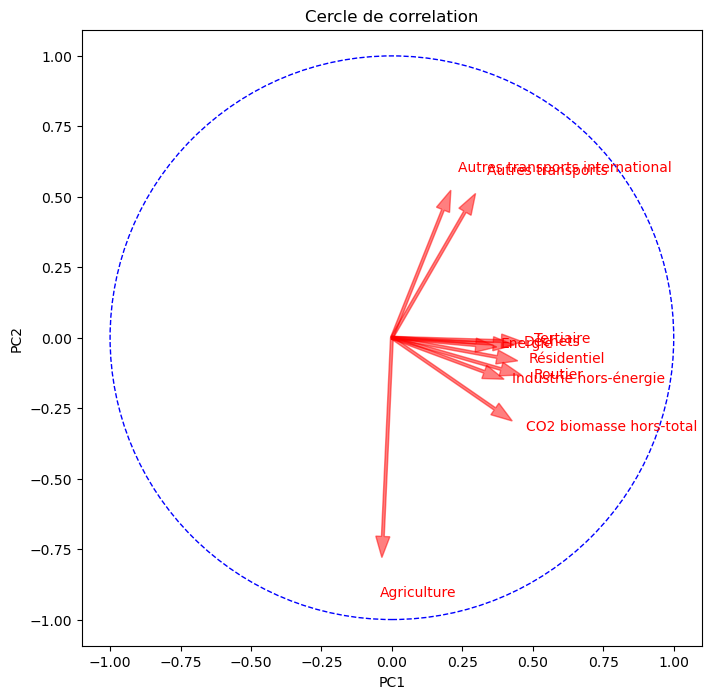

In [30]:
#ACP/CLusterring
numeric_columns = base_pollution.columns[base_pollution.dtypes == 'float64']
scaler = StandardScaler()
base_pollution_standardized = scaler.fit_transform(base_pollution[numeric_columns])


pca = PCA(n_components=2)
pca_result = pca.fit_transform(base_pollution_standardized)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)


plt.plot(range(1, 11), wcss)
plt.title('Heuristique du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Somme des carrés des distances intra-cluster')
plt.show()


optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
base_pollution['Cluster'] = kmeans.fit_predict(pca_df)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=base_pollution['Cluster'], cmap='viridis', alpha=0.5)

plt.colorbar(scatter, label='Cluster')
plt.title('Cluster par K-moyennes')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, fill=False, edgecolor='b', linestyle='dashed')
plt.gca().add_patch(circle)

for i, (pc1, pc2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, pc1, pc2, color='red', alpha=0.5, width=0.01, head_width=0.05)
    plt.text(pc1 * 1.3, pc2 * 1.3, numeric_columns[i], color='red')

plt.axis('equal')
plt.title('Cercle de correlation')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


Ces corrélations permettront de réduire le nombre de colonnes dans la partie modélisation. On remarque qu'il y a globalement trois tendances distinctes et que pour la plupart, ce sont des sources de pollution proches. 
Faire une telle distinction est utile dans une optique écologique et de contrôle des émission de certaines communes ou départements mais pour notre problématique, sommer certaines de ces colonnes du fait de leur proximité ne semble pas être très dérangean. 

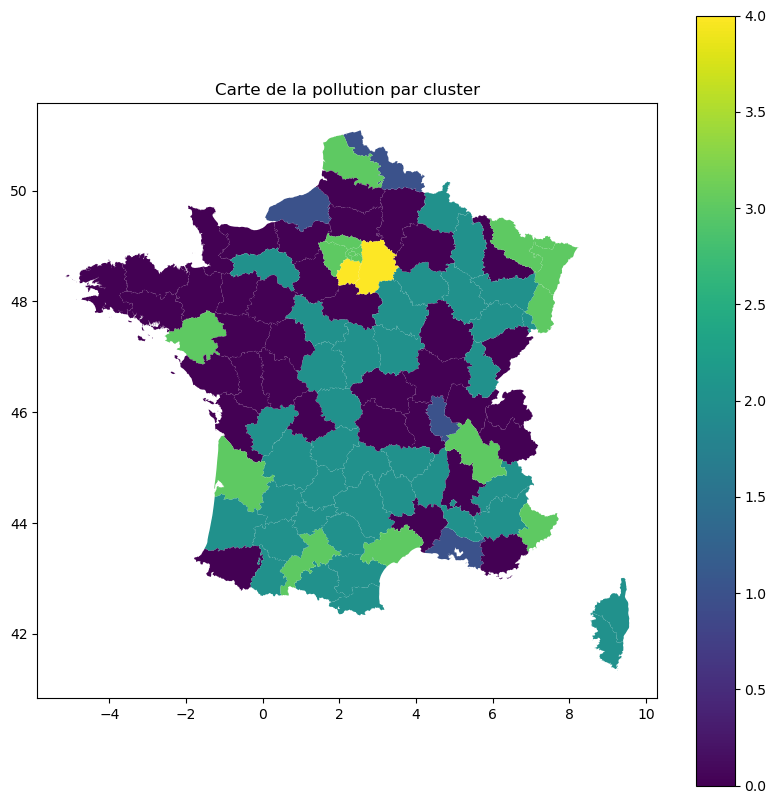

In [31]:
base_pollution = gpd.GeoDataFrame(base_pollution, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 10))
base_pollution.plot(column='Cluster', cmap='viridis', legend=True, ax=ax)
ax.set_title('Carte de la pollution par cluster')
plt.show()

In [32]:
base_pollution.loc[base_pollution['Cluster'] == 4]

Agriculture  Autres transports  \
nom                                                
Seine-et-Marne  642130.790536      419952.708598   
Essonne         156544.666716      839544.846964   

                Autres transports international  CO2 biomasse hors-total  \
nom                                                                        
Seine-et-Marne                     8.811581e+06            769604.506655   
Essonne                            1.257594e+06            728513.595823   

                      Déchets        Energie  Industrie hors-énergie  \
nom                                                                    
Seine-et-Marne  321083.328789  873569.141554            1.374792e+06   
Essonne         293317.174006  105597.205576            3.686388e+05   

                 Résidentiel       Routier      Tertiaire  \
nom                                                         
Seine-et-Marne  1.486174e+06  2.627508e+06  859823.542337   
Essonne         1.280296e+06  2.073377e+06  757884.411113   

                                                         geometry  Cluster  
nom                                                                         
Seine-et-Marne  POLYGON ((2.57166 48.69201, 2.57166 48.69345, ...        4  
Essonne         POLYGON ((2.22656 48.77610, 2.22866 48.77451, ...        4

In [33]:
#peut etre faire une rotation promax pour mieux voir 
#les deux seuls departements dans le cluster 4 sont la seine-et-marne et l essonne

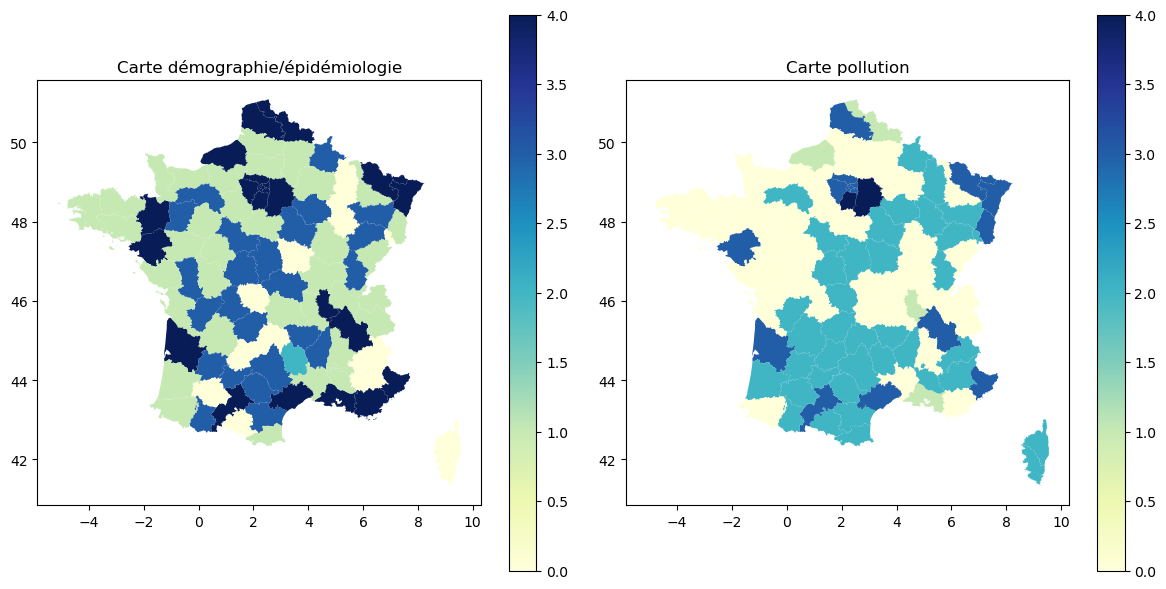

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


standard_ponderee.plot(ax=axs[0], column='Cluster', legend=True, cmap='YlGnBu')
axs[0].set_title('Carte démographie/épidémiologie')

base_pollution.plot(ax=axs[1], column='Cluster', legend=True, cmap='YlGnBu')
axs[1].set_title('Carte pollution')


plt.tight_layout()


plt.show()

Le résultat est en demie teinte. 
En effet il y a des similarités pour certains départements entre ceux deux cartes comme la région parisienne, une partie du Nord certains départements de l'est, l'Isère et le département du Rhône qui sont 'connus' pour être pollués. 
Néanmoins, il faut remttre en perspective le fait que ce sont les départements les plus peuplés de France et que par conséquent il y aura plus de cas dans ces départements là que dans d'autres. Par ailleurs, pour éviter d'avoir trop de 'biais de variables omises' il faut aussi souligner que les composantes principales de la carte de démographie/épidémiolgie sont principalement issues de la composition démographique du département et que les cluster se sont principalement sur ces différences. 
Il serait donc difficile, à partir de ces données, de clairement attribuer une part non négligeable des maladies respiratoires et cancers (entre autres) à la pollution. 

In [35]:
cluster_30_60 = pd.read_csv("df_cluster_30_60.csv")

In [36]:
cluster_30_60 = cluster_30_60.merge(france, how = 'left', left_on = 'dep', right_on = 'nom')

In [37]:
cluster_30_60 = gpd.GeoDataFrame(cluster_30_60, geometry='geometry')

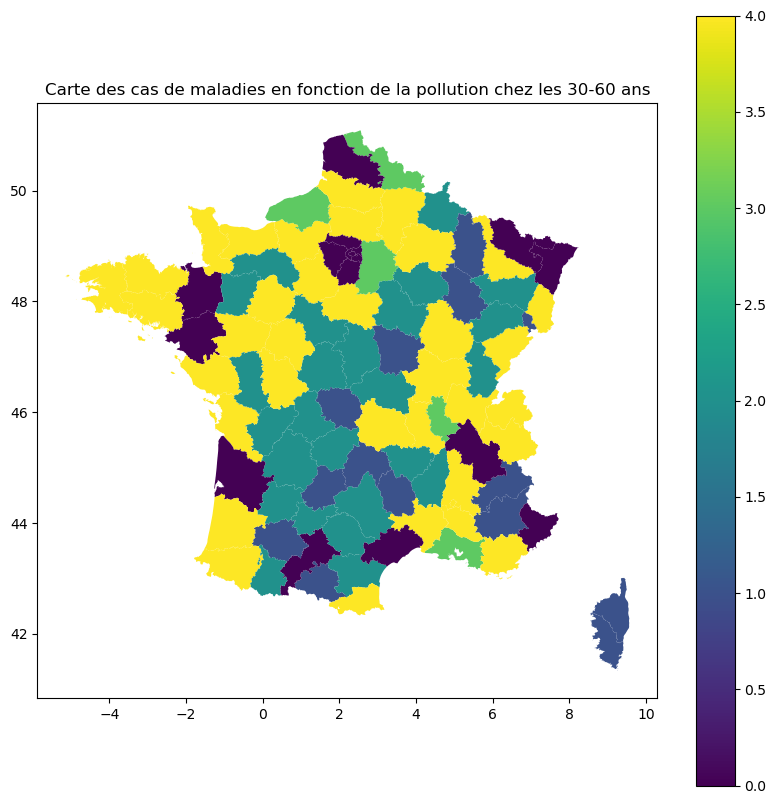

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
cluster_30_60.plot(column='cluster', cmap='viridis', legend=True, ax=ax)
ax.set_title('Carte des cas de maladies en fonction de la pollution chez les 30-60 ans')
plt.show()

On remarque ici que dans ce cas de figure, on ne constate pas de relation linéaire entre pollution et maladie, mais plutôt un effet seuil : la pollution 
devient vraiment significative à partir d'une certaine quantité de pollution. Ainsi, la pollution apparait siginificative par exemple à Paris et dans les bouches du rhône. 

# CONCLUSION DE LA PARTIE 

On retrouve des résultats assez similaires dans la mesure ou l'objectif principal de cette partie était de visualiser nos résultats. On a quand même 
néanmoins obtenus en fin de partie des informations supplémentaires sur la lien entre pollution et maladie : ce n'est pas une relation linéaire mais un effet seuil
qui lie les deux variables, autrement dit, à partir d'une certaine quantité de pollution donnée, la pollution à un impact significatif sur la contraction de 
pathologie au sein du département. On peut donc davantage expliquer par la pollution une prépondérance plu simportante de certaines maladie dans les départements
les plus touchés par une forte pollution. Cela pourrait par exemple expliquer le résultat mitigé de la prmière étude de cas sur la Bretagne, le taux de 
pollution du département ne permettant pas d'obtenir un nombre de cas significativement plus élevé. 


# CONCLUSION DU PROJET :

Ce travail nous apprend que l'on ne peut pas facilement déterminer l'état de santé des individus au sein d'un département en se focalisant sur quelques variables pécises qui peuevnt
de prime abord sembler caractériser le département. La seule variable qui a toujours un pouvoir prédictif satisfaisant c'est l'âge. La pollution aussi on l'a
vu a partir d'un certain seuil commence à avoir un effet intéressant. Donc en somme, ce que nous donne l'état de santé du département, c'est surtout
l'âge de la population et dans une certaine mesure son état de pollution. 

La réponse à la question est donc : non , il n'est pas pertinent de considérer le département dans le cadre d'une analyse de la santé de la population, 
excepté pour se référer à l'âge de ses résidents.
